<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Multivariate approaches: PCA, ICA, PLS, K-means</font></h1>



<div class = 'alert alert-info'>
In this lab, we are going to apply different multivariate techniques to fMRI data: PCA, Group ICA, K-means and PLS.
    
</div>

In [1]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

Instructions for the dataset:
- Download the data folder found in this link [here](https://drive.google.com/file/d/1kqDjve05xHxs76p1UymxubMFdPNur-My/view?usp=sharing)
- Move the downloaded data to MyFiles so that it remains and is also accessible from NeuroDesk (to see data of MyFiles from NeuroDesk refer to announcement [here](https://moodle.epfl.ch/mod/forum/discuss.php?d=107654))
- Unzip it so that your folder structure should look like this

```.
├── ICA_data
├── PCA_data
├── PLS_data
└── results
```



In [2]:
# Fill-in the path to unzipped folder
data_path = '../../resources/data/'

# 1. PCA 
<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Principal Component Analysis in fMRI</b></p>
        <p style='text-indent: 10px;'> fMRI analysis often requires to extract most representative spatial patterns from runs. A geometrical analogy would be to determine the main directions of a cloud of points. </p>
        <p style='text-indent: 10px;'> In this part we will use principal component analysis (PCA) to exactly perform the operations mentioned above. In here, the cloud of points would be the different volumes (TRs) and the dimensionality of our points would be of the order of a volume.</p>
        <p> In the context of fMRI data analysis, PCA can be used to extract the most representative spatial patterns from the data. By treating timepoints as samples and voxels as features, PCA helps in identifying the main directions of variance in the brain activity data. </p>
    </span>
</br>

<u>Brief theoretical description</u>:
PCA is a statistical technique used to simplify a dataset by reducing its dimensionality while retaining most of the variation in the data. It achieves this by transforming the data into a new coordinate system where the greatest variances by any projection of the data come to lie on the first coordinates (called principal components), the second greatest variances on the second coordinates, and so on.

Given a dataset $\mathbf{X}$ with $n$ samples and $p$ features, PCA aims to find a set of orthogonal vectors (principal components) that capture the maximum variance in the data. The steps involved in PCA are:

1. **Center the Data**: Center the data by subtracting the mean of each feature.
    $$
    \mathbf{X}_{\text{centered}} = \mathbf{X} - \mathbf{\mu}
    $$
    where $\mathbf{\mu}$ is the mean vector of $\mathbf{X}$.

2. **Compute the Covariance Matrix**:
    $$
    \mathbf{C} = \frac{1}{n-1} \mathbf{X}_{\text{centered}}^T \mathbf{X}_{\text{centered}}
    $$

3. **Eigen Decomposition**: Calculate the eigenvalues and eigenvectors of the covariance matrix $\mathbf{C}$.
    $$
    \mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i
    $$
    where $\lambda_i$ are the eigenvalues and $\mathbf{v}_i$ are the corresponding eigenvectors.

4. **Sort Eigenvalues and Eigenvectors**: Sort the eigenvalues in descending order and arrange the corresponding eigenvectors to form the principal components.

5. **Select Eigenvectors of interest**: Select eigenvectors associated with largest eigenvalues

### Load the data

In [3]:
img = nib.load(op.join(data_path,'PCA_data/ds114_sub009_t2r1.nii'))
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(64, 64, 30, 173)

### Preprocessing 

We can think of the shape of the data as two parts - the first 3 values are the 3D shape of the individual volumes, and the last value is the number of volumes. Put the 3D shape into a variable vol_shape and the number of volumes into a variable n_vols:

In [4]:
# Make variables:
# 'vol_shape' for shape of volumes
# 'n_vols' for number of volumes
# YOUR CODE HERE
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

When applying PCA, a question that we need one needs to ask is, what are the features and what are the samples? Here in this context, we will take the timepoints as being the “samples” and the voxels to be the features. Note however that per volume there are many useless voxels, such as the background. We will first be removing it, and flattening volume into a vector.

In [5]:
# YOUR CODE HERE
# Note: In our case the background is encoded as 0 
# you can consider that the first volume's background 
# voxels are the same as all following volumes

slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
# (NOTE: that the order is important)
samples = data[slice_non_background]

Next up we will be removing the spatial mean across timepoints from each timepoints. Calculate the mean spatial pattern and perform the substraction operation.

In [30]:
# YOUR CODE HERE
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))
# Subtract the means for each row, put the result into X
X = samples - row_means
# Verify that the spatial mean behaves as expected after substraction
assert np.abs(X.mean(axis=-1)).max() < 1e-10

### Components Extraction

By applying PCA on the temporal axis (i.e features being the spatial map and samples being the timepoints), we are effectively finding representatives of spatial clusters. In our application, the components we find would then intuitively be patterns that "represent" best the full run. 

While we can set `nb_components` to an arbitrary value , the number of relevant components is to selected either arbitrarily (after visualization) or according to a criterion such as the [Elbow Criterion](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

To apply PCA, we can use scikit-learn PCA model: [PCA](https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html)

In [25]:
from sklearn.decomposition import PCA
nb_components = 10

# YOUR CODE HERE 

pca = PCA(n_components=nb_components)
pca.fit(X.T) # NOTE: Takes matrix of shape (nb_samples, nb_features)

PCA(n_components=10)

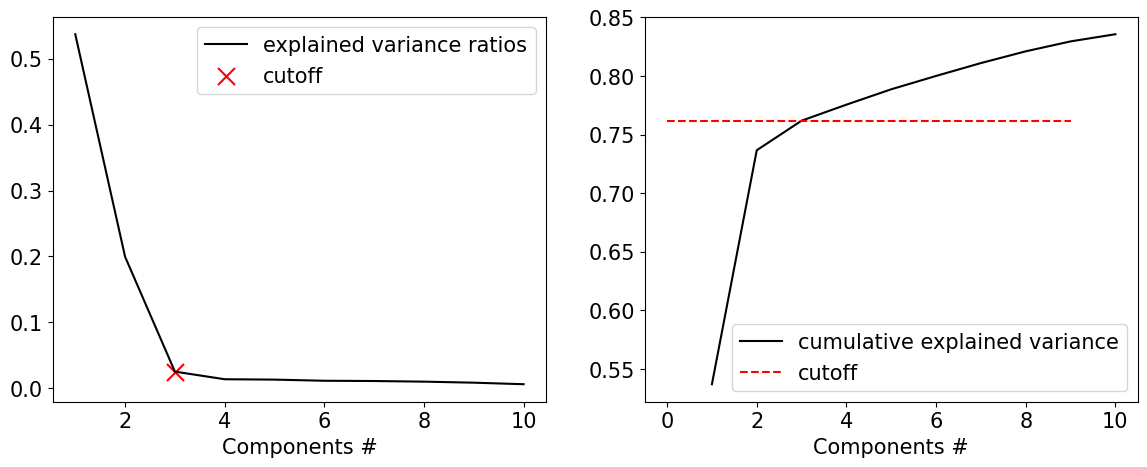

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 3

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

Now that we selected components of interest let's bring the vectors back to the original spatial domain. Practically speaking, you will have to reshape the components back to the original volume shape, while remembering that we removed the background voxels. (Hint: `slice_non_background` would be of use)

In [28]:
# YOUR CODE HERE 
pca_clusters = [] # List of spatial components (you should have in the list elements of the shape 30)
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)

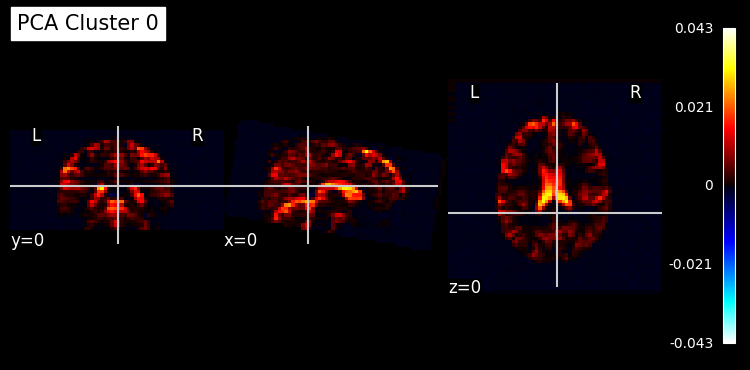

In [29]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[0,0,0], black_bg=True,
              title=f'PCA Cluster {visual_idx}')

plt.show()

# 2. Temporal K-means
<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Temporal K-means in fMRI</b></p>
        <p style='text-indent: 10px;'> In the same spirit as for PCA, K-means is a clustering method enabling components extraction.
        Leveraging a given definition of distance (i.e cosine distance, euclidean distance etc...), K-means finds distance minimizing components to cover all samples</p>
        <p style='text-indent: 10px;'> Similar to how we applied PCA, we will consider timepoints to be samples and voxels to be features. Clustering would yield the main spatial patterns that "appear" during the timecourse.</p>
    </span>
</br>

<u>Brief theoretical description</u>:
K-means is a popular clustering algorithm used to partition a dataset into $K$ distinct, non-overlapping subsets (clusters). The standard algorithm aims to minimize the within-cluster variance, which is the sum of squared distances between each data point and the centroid of its assigned cluster. (the formulation can also be extended to minimize a different distance metric)

Given a dataset $\mathbf{X} = \{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n \}$ with $n$ samples, the steps involved in K-means are:

1. **Initialization**: Randomly select $K$ initial centroids $\{ \mathbf{\mu}_1, \mathbf{\mu}_2, \ldots, \mathbf{\mu}_K \}$.

2. **Assignment Step**: Assign each data point to the nearest centroid based on the Euclidean distance. For each data point $\mathbf{x}_i$, find the closest centroid $\mathbf{\mu}_j$:
    $$
    c_i = \arg\min_{j} \| \mathbf{x}_i - \mathbf{\mu}_j \|^2
    $$
    where $c_i$ is the cluster assignment for data point $\mathbf{x}_i$.

3. **Update Step**: Recalculate the centroids as the mean of all data points assigned to each cluster:
    $$
    \mathbf{\mu}_j = \frac{1}{|C_j|} \sum_{\mathbf{x}_i \in C_j} \mathbf{x}_i
    $$
    where $C_j$ is the set of data points assigned to cluster $j$ and $|C_j|$ is the number of data points in cluster $j$.

4. **Convergence**: Repeat the assignment and update steps until the centroids no longer change or the change is below a predefined threshold.

The objective of K-means is to minimize the within-cluster sum of squares (WCSS), also known as the inertia:
$$
\text{WCSS} = \sum_{j=1}^{K} \sum_{\mathbf{x}_i \in C_j} \| \mathbf{x}_i - \mathbf{\mu}_j \|^2
$$

This inertia can be used to decide in a less arbitrary way the numbers of cluster.

Additional description and formulation can be found [here](https://en.wikipedia.org/wiki/K-means_clustering).

To apply K-Means, we can use scikit-learn KMeans implementation: [KMeans](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)

In [55]:
from copy import deepcopy
# We will be using the same data for as in PCA
# Thus the background are also not taken in feature vectors
X_kmeans = deepcopy(X)

In [56]:
from sklearn.cluster import KMeans

max_nb_clusters = 10
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
    avg_dist_samples.append(kmeans.inertia_)

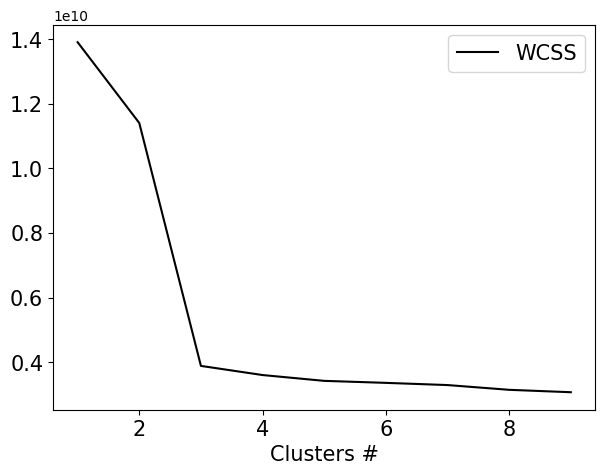

In [60]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, len(avg_dist_samples)+1), avg_dist_samples, label='WCSS', c='k')

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

In [14]:
# YOUR CODE HERE

nb_clusters = 3 # The number of clusters you want
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = []
for cluster_idx in range(nb_clusters):
    kmeans_component = np.zeros(vol_shape)
    kmeans_component[slice_non_background] = kmeans.cluster_centers_[cluster_idx]
    kmeans_clusters.append(kmeans_component)

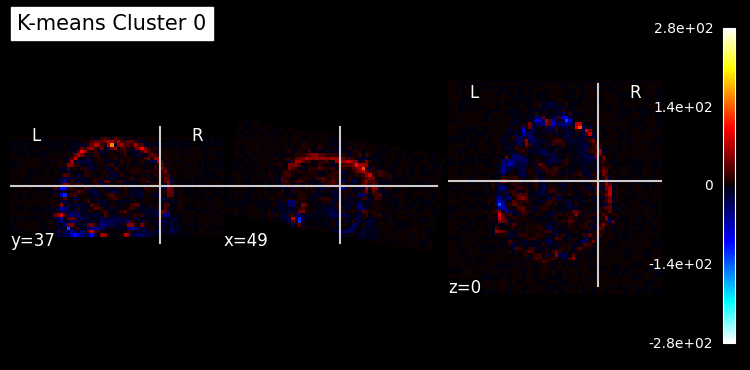

In [15]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(kmeans_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {visual_idx}')

plt.show()

# 3. PLS
<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Partial Least Squares in fMRI</b></p>
        <p style='text-indent: 10px;'> While both PCA and Partial Least Squares (PLS) employ the same method of Singular Value Decomposition (or eigendecomposition of the covariance matrices), they are applied on different samples. PLS is used to find the fundamental relation between two sample sets through decomposition of the covariance of the two sets.</p>
        <p style='text-indent: 10px;'> In this part we will use PLS in combination with behavioural scores specific to each subjects, and determine relationship between the two spaces of fMRI and behavioural scores across subjects. Some examples of behavioural scores in neuroimaging include medical condition, age, personality scores obtained through questionnaires etc...</p>
    </span>
</br>

<u>Brief theoretical description</u>:
Partial Least Squares (PLS) is a statistical method used to find the fundamental relations between two matrices (predictor and response variables) by projecting them into a new space. It is particularly useful when the predictor variables are highly collinear or when the number of predictors exceeds the number of observations.

Given two matrices $\mathbf{X} \in \mathbb{R}^{n \times p}$ (predictor variables) and $\mathbf{Y} \in \mathbb{R}^{n \times q}$ (response variables), PLS aims to find the latent vectors $\mathbf{L_X}$ and $\mathbf{L_Y}$ such that:

$$
\mathbf{X} = \mathbf{L_X} \mathbf{W}^T + \mathbf{E}
$$

$$
\mathbf{Y} = \mathbf{L_Y} \mathbf{Q}^T + \mathbf{F}
$$

where $\mathbf{L_X}$ and $\mathbf{L_Y}$ are the scores (latent variables), $\mathbf{W}$ and $\mathbf{Q}$ are the loadings, and $\mathbf{E}$ and $\mathbf{F}$ are the residuals.

The steps involved in PLS are:

1. **Standardize the Data**: Center and scale the data matrices $\mathbf{X}$ and $\mathbf{Y}$.

2. **Compute the Covariance Matrix**:
    $$
    \mathbf{R} = \mathbf{Y} \mathbf{X}^T
    $$

3. **Decompose the Covariance Matrix**: Perform Singular Value Decomposition (SVD) on the covariance matrix $\mathbf{R}$:
    $$
    \mathbf{R} = \mathbf{U} \mathbf{D} \mathbf{V}^T
    $$
    where $\mathbf{U}$ and $\mathbf{V}$ are the left and right singular vectors, and $\mathbf{D}$ is the diagonal matrix of singular values.

4. **Calculate the Latent vectors**:
    $$
    \mathbf{L_X} =  \mathbf{V}^T \mathbf{X}
    $$
    $$
    \mathbf{L_Y} =  \mathbf{U}^T\mathbf{Y}
    $$
By association, you notice that the loadings information are contained in the singular vectors.

PLS maximizes the covariance between the scores of $\mathbf{X}$ and $\mathbf{Y}$, ensuring that the extracted components explain as much variance as possible in both matrices.

For the PLS analysis, we are going to use $n=20$ subjects with one contrast map (image, dim: [91, 109, 91] ) per subject. So in total, the number of input imaging data ($\textbf{X}$) is 20 flattened contrast maps ($X_{im} \in {\rm I\!R^{d_{im} \times n}}, d_{im}= 902629, n = 20$) ). 
    
For the behavioural input data ($\textbf{Y}$), two behavioural scores per subjects are used ($Y_{beh} \in {\rm I\!R^{d_{beh} \times n}}, d_{beh}= 2, n = 20$) ).

### Read contrast maps of all subjects

In [40]:
#* Read  contrast maps of all subjects and build the X matrix
data_dir_template = op.join(data_path,'PLS_data/sub_{}/contrastMap.nii')

N_subj = 20                      # Number of subjects
tmp    = nib.load(data_dir_template.format(1))
x1, y1, z1 = tmp.shape              # voxel size of the contrast maps

tmp    = tmp.get_fdata().flatten()
N_vox  = tmp.shape[0]    # Number of voxels
del tmp

#* initialize X
X      = np.zeros((N_vox, N_subj)) # voxel_num X subj_num

for i in range(N_subj):
    voxel_array = nib.load(data_dir_template.format(i+1)).get_fdata().flatten()
    X[:,i]      = voxel_array.copy()
    
X      = zscore(X, axis = 0) # z-scoring voxel activity across subjects
X      = np.nan_to_num(X,0) # replace nan with 0s

print("X matrix size: ", X.shape)

X matrix size:  (902629, 20)


### Read behavioral data 

In [41]:
#* Read behavioral data and build the Y matrix
behVar = loadmat(op.join(data_path, 'PLS_Data/behavior.mat'))['behVar']

Y = np.zeros(behVar.shape) # size: N_beh x N_subj
Y[0,:] = zscore(behVar[0,:])    # z-scoring of the first measure
Y[1,:] = zscore(behVar[1,:])    # z-scoring of the second measure

print("Y matrix size: ", Y.shape)

Y matrix size:  (2, 20)


### Build the cross-correlation matrix R and apply SVD

In [42]:
#* Build the cross-correlation matrix (R)
R     = np.dot(Y,X.T); # size: N_beh x N_vox
print("R matrix size: ", R.shape)

#* Do Singular Value Decomposition (SVD) of R 
# (Note that numpy has inbuilt function for SVD)
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
# U: N_beh x N_beh, D: N_beh x 1, V.T: N_beh x N_vox 
# Remember to that you do not need to compute the full matrix
# YOUR CODE HERE
U, D, Vt = np.linalg.svd(R, full_matrices = False)
V = Vt.T

print("U matrix size :", U.shape, "D matrix size :", D.shape, "V matrix size :", Vt.shape)

#* Get the Latent Variables LVs
# Lx (size: N_beh x N_subj)
# Ly= (size: N_beh x N_subj)
# YOUR CODE HERE

Lx = np.matmul(Vt, X)
Ly = np.matmul(U.T, Y)

print("Latent var x :", Lx.shape, "Latent var y :", Ly.shape)
print('Number of singular values is equal to the number of behavioral measures: ', D.shape[0])

R matrix size:  (2, 902629)
U matrix size : (2, 2) D matrix size : (2,) V matrix size : (2, 902629)
Latent var x : (2, 20) Latent var y : (2, 20)
Number of singular values is equal to the number of behavioral measures:  2


### Plot singular values, behavioral components and spatial components


 The Singular values:  [2552.18920751   12.92148597]


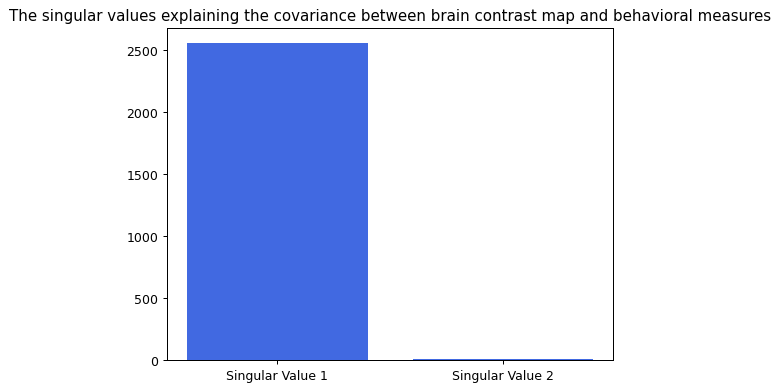

In [45]:
#* Plot singular values explaining the covariance between brain contrast maps and behavioral measures

plt.figure(dpi=90)
plt.bar([1,2], D,color='royalblue')
plt.xticks([1, 2], ['Singular Value 1', 'Singular Value 2'])
plt.title("The singular values explaining the covariance between brain contrast map and behavioral measures")


# YOUR CODE HERE
# Print the Sigular values
print("\n The Singular values: ", D)

Singular values derived from the covariance matrix show the amount of covariance explained by their corresponding left and right singular vectors. Comparing among singular values allow to understand the relative importance of a vector.

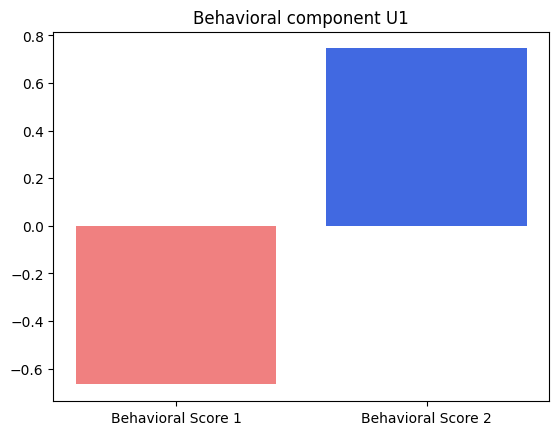

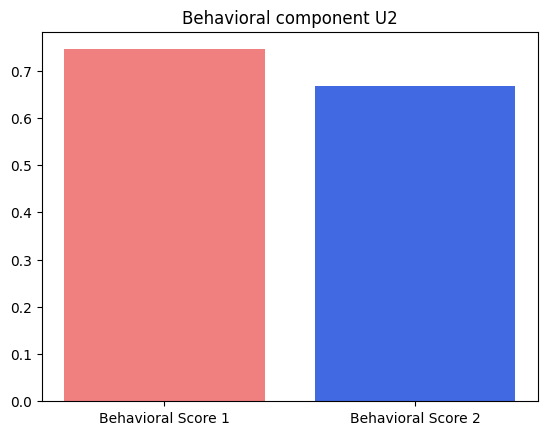

In [46]:
#* Plot the behavioral components (matrix U)

# Plot Behavioral Component U1
plt.bar([1,2], U[0,:], color=['lightcoral','royalblue'])
plt.xticks([1, 2], ['Behavioral Score 1', 'Behavioral Score 2'])
plt.title("Behavioral component U1")
plt.show()

# Plot Behavioral Component U2
# YOUR CODE HERE
plt.bar([1,2], U[1,:], color=['lightcoral','royalblue'])
plt.xticks([1, 2], ['Behavioral Score 1', 'Behavioral Score 2'])
plt.title("Behavioral component U2")
plt.show()

Patterns found from the behavioral components highlight a certain profiles of behaviours (e.g low score 1 and high score 2). These profiles are associated to a spatial pattern. Intuitively, subjects (since we are computing covariance across subjects) that exhibit such a behaviour profile, also exhibits the associated spatial pattern. 

In [36]:
#* Information needed for plotting
#* Read T1-weighted template
T1w_img = nib.load(op.join(data_path, 'PLS_data/T1w_restore_brain.nii'))

# Get affine transform
affine = nib.load(data_dir_template.format(1)).affine

Spatial Component V1
Spatial Component V2


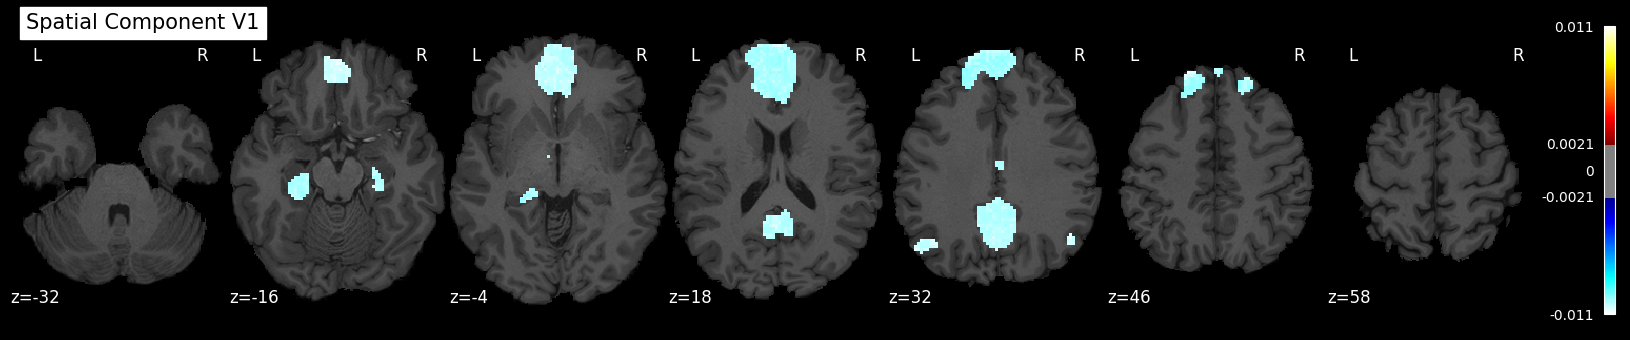

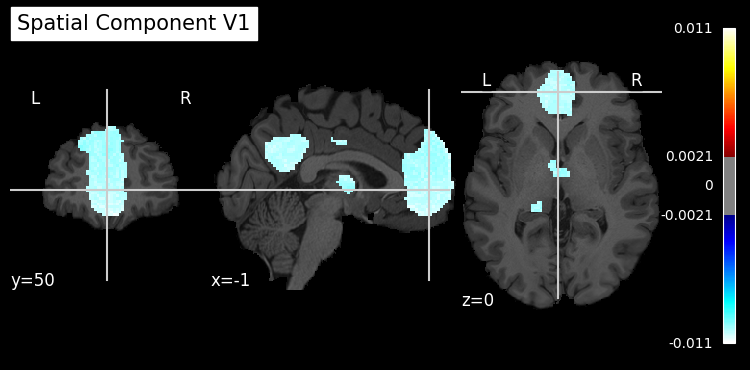

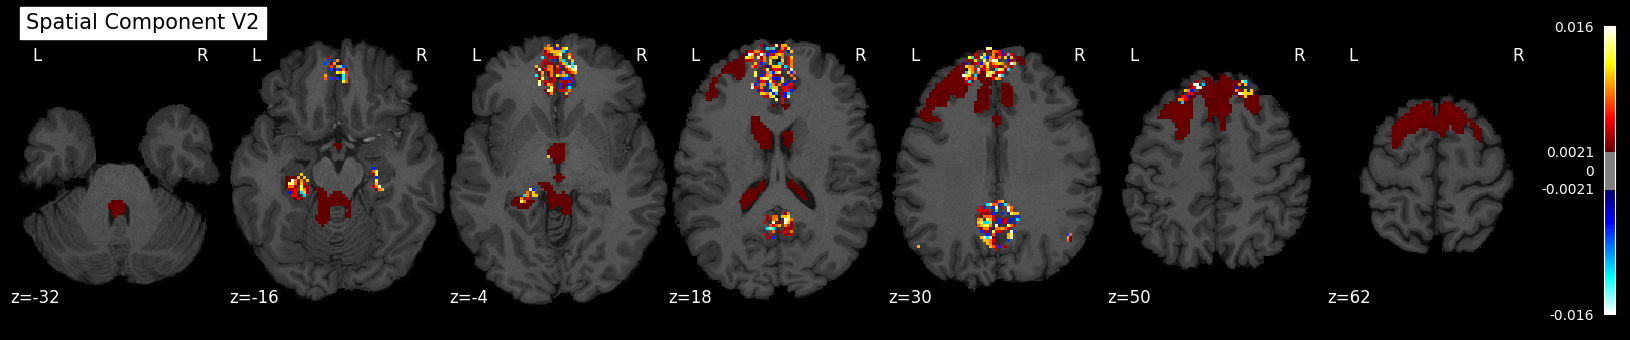

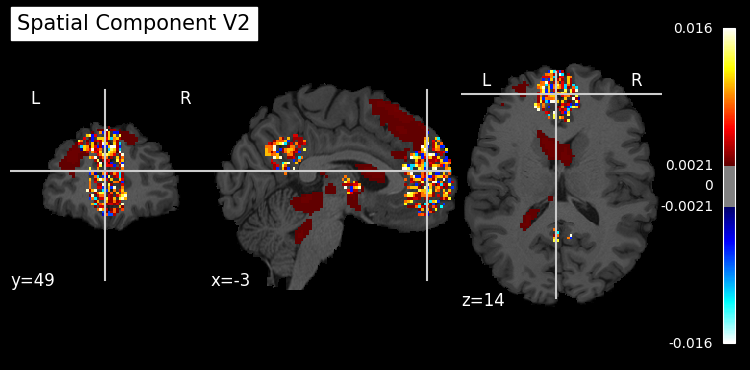

In [39]:
#* Plot the spatial components (matrix V)
print('Spatial Component V1')
V1_img = nib.Nifti1Image(np.reshape(V[:,0],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V1_img, display_mode=view_, title='Spatial Component V1',
                    colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[:,0]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot
        
print('Spatial Component V2')  
# YOUR CODE HERE
V2_img = nib.Nifti1Image(np.reshape(V[:,1],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V2_img, display_mode=view_, title='Spatial Component V2',
                colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[:,1]),)
                #output_file=save_results + "pls_spatial_V2_{}.png".format(view_)) # uncomment to save plot


Note that the area highlighted correspond to Posterior Cingulate Cortex (PCC) and the Medial Prefrontal Cortex (mPFC) - belonging to the so called DMN - and that those regions contribute significantly to the brain-behavior covariance matrix R.

# 4. Spatial & Temporal ICA 
<br>
<div class="warning" style='background-color:#90EE90; color: #805AD5; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
    <span>
        <p style='margin-top:1em; text-align:center'><b>Temporal / Spatial - Independant Component Analysis in fMRI</b></p>
        <p style='text-indent: 10px;'> A different yet similar method to PCA, to perform component extraction is to use ICA. ICA works on the assumption of underlying source to be statistically independent and often finds these sources by maximizing non gaussianity of sources.</p>
        <p style='text-indent: 10px;'> In this section we show multiple applications of ICA, temporally, spatially (toy example) and in a group setting (real example). Temporal and spatial ICA differs in whether samples are timepoints or voxels.</p>
    </span>
</br>

<u>Brief theoretical description</u>: Independent Component Analysis (ICA) is a computational technique used to separate a multivariate signal into additive, independent components. It is particularly useful in the field of signal processing and data analysis, where the goal is to identify underlying factors or sources from observed data.

Given a set of observed signals $\mathbf{X}$, ICA assumes that these signals are linear mixtures of some unknown independent sources $\mathbf{S}$, combined through an unknown mixing matrix $\mathbf{A}$:

$$
\mathbf{X} = \mathbf{A} \mathbf{S}
$$

The objective of ICA is to estimate both the mixing matrix $\mathbf{A}$ and the source signals $\mathbf{S}$, such that the components of $\mathbf{S}$ are statistically independent. This can be achieved by finding an unmixing matrix $\mathbf{W}$ such that:

$$
\mathbf{S} = \mathbf{W} \mathbf{X}
$$

where $\mathbf{W}$ is the inverse of the mixing matrix $\mathbf{A}$.
To find such a mixing (unmixing) matrix, various criterion can be used. 
ICA typically maximizes the non-Gaussianity of the source signals, as measured by metrics such as negentropy or kurtosis.

In order to understand the main process, let's start with a toy-example: a 2D image (x-y) whose pixels are associated to a time-series. To simplify and simulate that this 2D image might change in time, we will consider 3 channels (3 different states that correspond to the ground truth 3 components that we want to emulate). 

In this way we are trying to simplify what we have in real data fMRI: a volume (3D) that represents the brain with its time-varying activity (4th dimension).

Let's start with generating a simulated image that is characterized by 3 clear groups that we want to distinguish and identify with ICA.


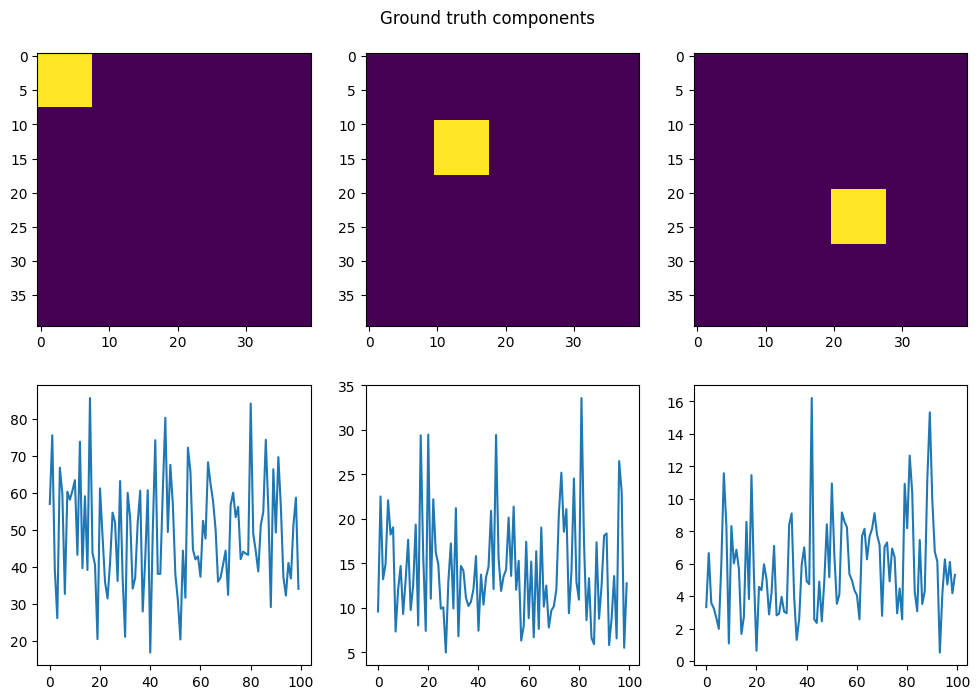

In [14]:
nTRs=100 # number of timepoints in the fMRI timecourse
nComps=3 # number of ground-truth components

# put together synthetic data (2D x time)
t=range(0,nTRs) 
pS=8 # patch size (size of each small square/ground truth group)
iS=40 # image size

I = np.zeros([3,iS,iS])
T = np.empty([3,1,1,nTRs])

# channel 0
I[0,:,:]=np.zeros([iS,iS])
I[0,:,:][0:0+pS,0:0+pS]=1
T[0]=np.random.gamma(10,5,[1,1,nTRs])
# channel 1
I[1,:,:]=np.zeros([iS,iS])
I[1,:,:][10:10+pS,10:10+pS]=1
T[1]=np.random.gamma(5,3,[1,1,nTRs])
# channel 2
I[2,:,:]=np.zeros([iS,iS])
I[2,:,:][20:20+pS,20:20+pS]=1
T[2]=np.random.gamma(3,2,[1,1,nTRs])

# plot ground truth images and time courses of the 3 channels, with the corresponding timeseries
# Hint: use imshow for the matrix

### YOUR CODE HERE
fig = plt.figure(figsize=[12,8])
plt.subplot(2,3,1) 
plt.imshow(I[0])

plt.subplot(2,3,2) 
plt.imshow(I[1])
plt.subplot(2,3,3) 
plt.imshow(I[2]) 
plt.subplot(2,3,4)
plt.plot(np.squeeze(T[0]))
plt.subplot(2,3,5); 
plt.plot(np.squeeze(T[1]))
plt.subplot(2,3,6); 
plt.plot(np.squeeze(T[2]))
fig.suptitle('Ground truth components',y=0.93)
plt.show()

To apply ICA, we can use scikit-learn ICA implementation: [ICA](https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.FastICA.html)

In [15]:
# Generate fake fMRI data (in 3D instead of 4D)
# shaping the data into 3D data object

data=np.zeros([iS,iS,nTRs])
for i in range(nComps):
    # repeat the 3 states that we want to identify with the spatial ICA
    repeatedI = np.array([I[i] for x in range(nTRs)]).T
    data=data+repeatedI*np.tile(T[i],[iS,iS,1])

# RUN Spatial ICA

## FastICA (reorient data in 2D matrix)
## Lecture slides show convention: 1 observation in 1 row
## FastICA Python toolbox assumes 1 observation in 1 column

x = np.reshape(data,[iS*iS, nTRs])
print("The X matrix has dimensions {} and it's going to be used as input to spatial or temporal ICA. \n\
Be careful for the distinction of the 2!\n".format(x.shape))

# perform ICA using the algorithm FastICA imported from sklearn.decomposition 
# (CHECK THE DOCUMENTATION TO SEE HOW TO USE IT)

### YOUR CODE HERE

## First: use ICA on the SPATIAL axis
icas = FastICA(n_components=nComps)#, random_state=9
icasig_space = icas.fit_transform(x)  # Spatial source signals

## Then apply again ICA but on the temporal axis 
icat = FastICA(n_components=nComps) #, random_state=9
icasig_time = icat.fit_transform(x.T)  # Temporal source signals


## Then reshape spatial sources into 2D images
C = np.empty([nComps, iS, iS])
for i in range(nComps):
    C[i]=np.reshape(icasig_space[:,i],[iS,iS])
    
print("The shape of C is :", C.shape)

The X matrix has dimensions (1600, 100) and it's going to be used as input to spatial or temporal ICA. 
Be careful for the distinction of the 2!

The shape of C is : (3, 40, 40)


Now, try to re-run the same code doing 2 changes at the time:

1) Increasing the value of the variable of the patch size `pS` to 12, meaning that we will create a small overlap between the blocks;

2) Changing the number of components of only the ICA (keeping the ground truth to 3).

Run the ICA again a few times and observe the results. What can you say with respect to the sorting and sign of the components? What about increasing the patch size?

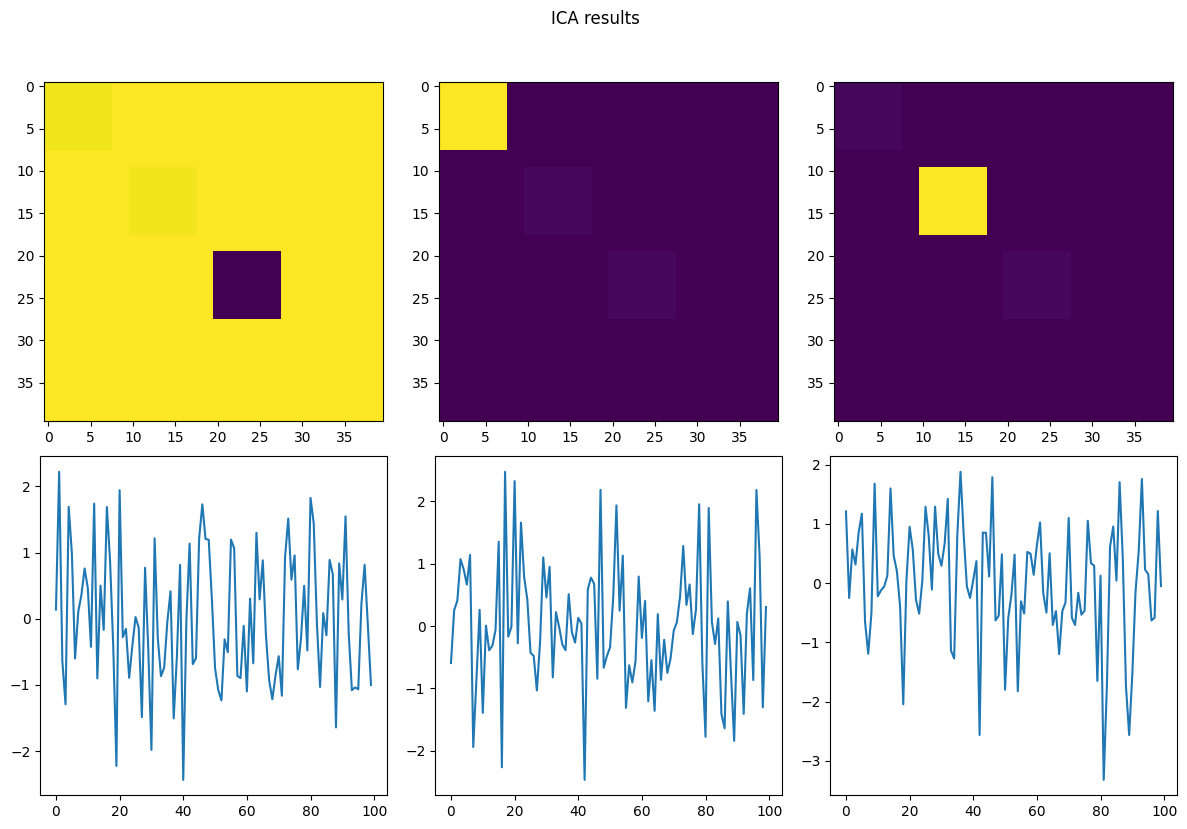

In [16]:
# Now plot spatial and temporal ICA sources similarly as before:
# the 3 NxN matrices (in space) with the respective time components stored in the variable icasig_t

### YOUR CODE HERE

fig = plt.figure(figsize=[12,8])
plt.suptitle('ICA results',y=1.03)

plt.subplot(2,3,1)
plt.imshow(C[0])

plt.subplot(2,3,2)
plt.imshow(C[1])

plt.subplot(2,3,3)
plt.imshow(C[2])

plt.subplot(2,3,4)
plt.plot(np.squeeze(icasig_time[:,0]))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(2,3,5)
plt.plot(np.squeeze(icasig_time[:,1]))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(2,3,6)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(np.squeeze(icasig_time[:,2]))

plt.tight_layout()
plt.show()

## Group ICA 

For the Group ICA analysis, we are going to use data from studyforrest. Subjects are watching the movie "forrest gump" during fMRI acquisition. Here we take $n=15$ subjects with 200 smoothed volumes (image dim: [61, 73, 61] ) per subject. So in total, the number of input imaging data  concatenated across subjects is: $$X \in {\rm I\!R^{(n _{subj}\times n_{images}) \times d}}$$ with $$n_{subj} = 15, n_{images}=200, d = 271633$$

Note that we only take a small part of the movie (1/8th)

Citation: Hanke, M., Adelhöfer, N., Kottke, D. et al. A studyforrest extension, simultaneous fMRI and eye gaze recordings during prolonged natural stimulation. Sci Data 3, 160092 (2016). https://doi.org/10.1038/sdata.2016.92

In [17]:
# Prepare data

path_func_img = op.join(data_path, 'ICA_data/StudyForest/s01run1/s6wCov_rfrun-1_bold001.nii')
img_ex = nib.load(path_func_img)

# Get affine transform -- check nibabel library for more info!
affine = nib.load(path_func_img).affine
x,y,z = img_ex.shape

N_vol=200
N_subj=8 ## NOTE: You can increase or decrease the number of subjects
N_tot=N_vol*N_subj

#* Initialize X
X = np.zeros((N_tot,x*y*z)) # total_timepoints(15subj*200timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk(op.join(data_path, 'ICA_data/StudyForest/'))):
    if len(files)!= 0:
        nb_subj_counted=nb_subj_counted+1
        if nb_subj_counted > N_subj:
            break
        print(f"Loading subject {nb_subj_counted}")
    for j in trange(len(files)):
        file = sorted(files)[j]
        if file.endswith('.nii'):
            if nb_subj_counted<N_subj+1:
                X[n_nii,:] = nib.load(root+'/'+file).get_fdata().flatten()
                n_nii+=1

X = zscore(X, axis = 1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

Loading subject 1


  0%|          | 0/1 [00:00<?, ?it/s]

Loading subject 2


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 3


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 4


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 5


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 6


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 7


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 8


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 9


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 10


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 11


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 12


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 13


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 14


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 15


  0%|          | 0/200 [00:00<?, ?it/s]

Loading subject 16


  0%|          | 0/200 [00:00<?, ?it/s]

X matrix size:  (1600, 271633)


**Visualize the data in FSLeyes or here using nibabel.**

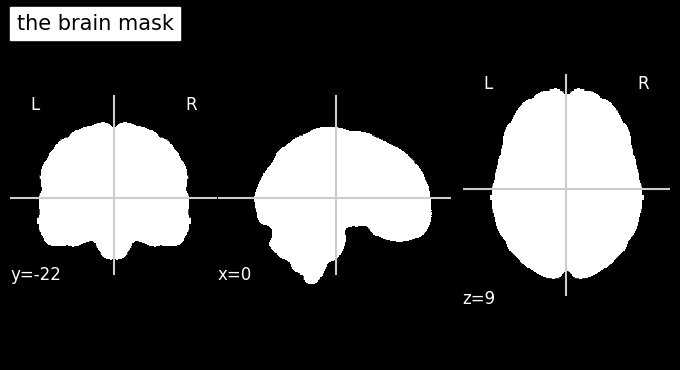

In [18]:
#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

<div class = 'alert alert-info'>

**Note:** In the lecture's slides the ICA model was defined as $X = S A$.  The matrix $A$ was the mixing matrix. Here, the Fast ICA model is defined as: $S = X W$. The matrix $W$ is the un-mixing matrix (inverse of $A$).
</div>

In [19]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,]#10]#20, 60 ...]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(271633, 4)
Done


In [20]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (271633, 4)


In [21]:
#* Read T1-weighted template
T1w_img = nib.load(op.join(data_path, 'PLS_data/T1w_restore_brain.nii'))

Number of components:  4


/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


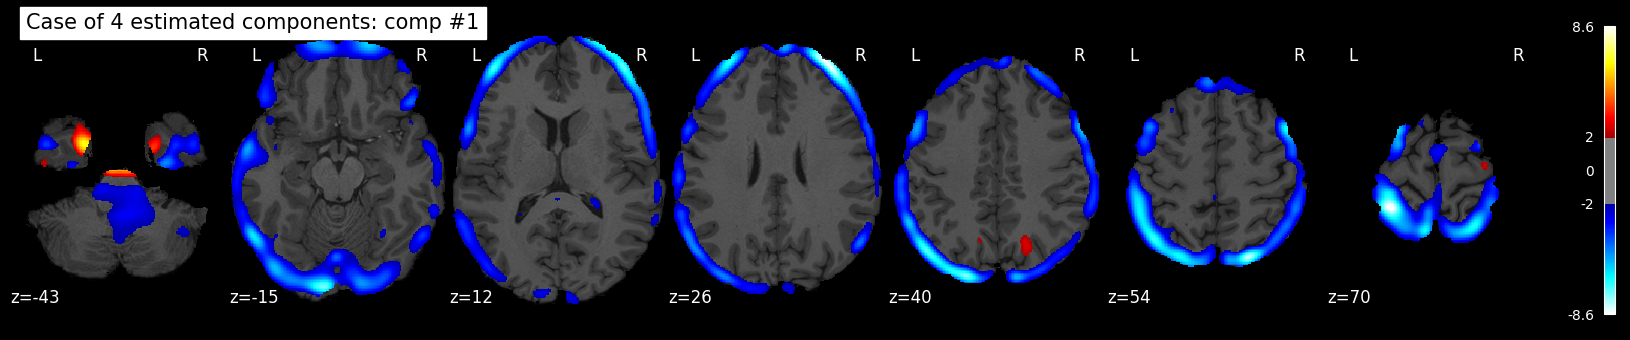

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


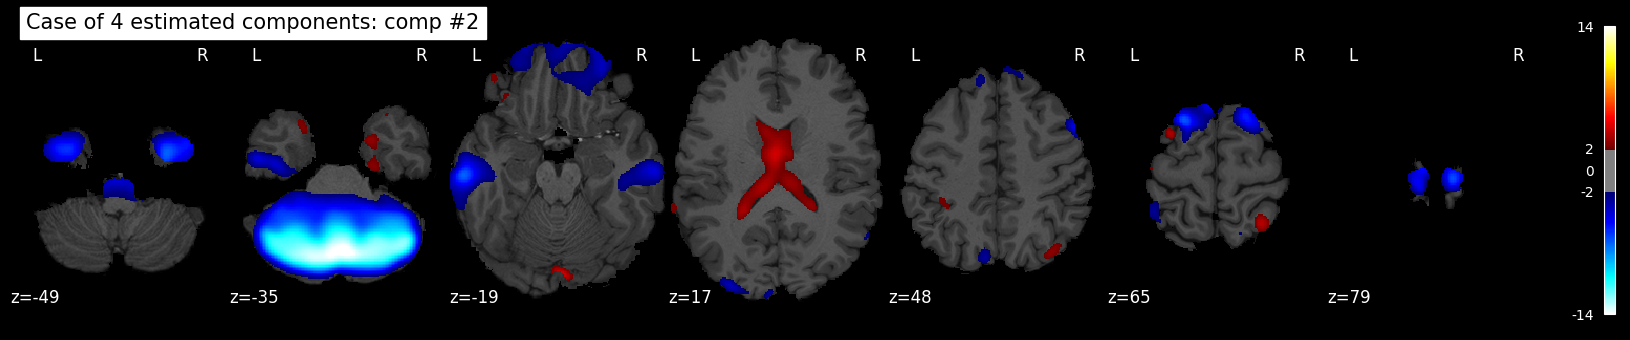

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


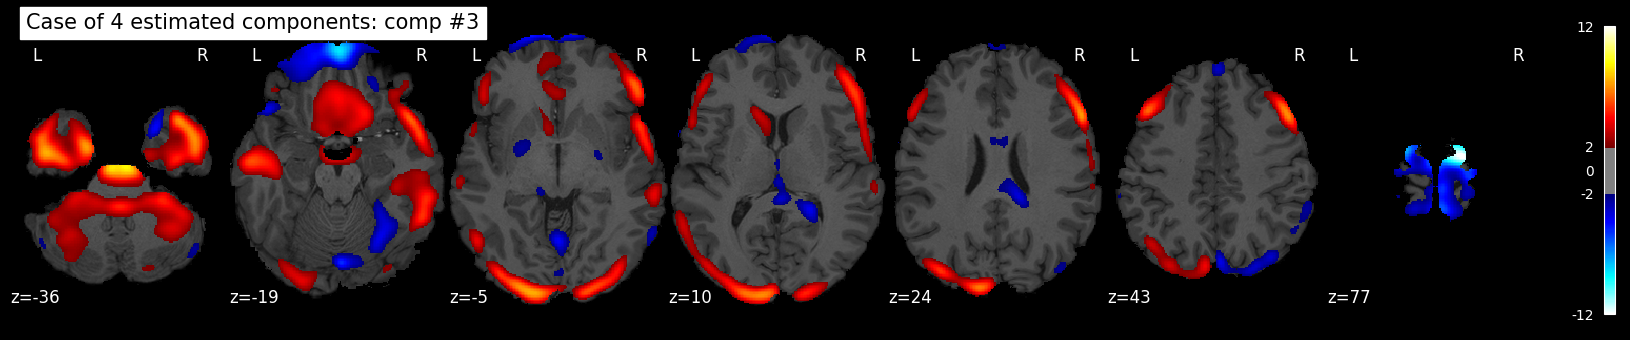

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


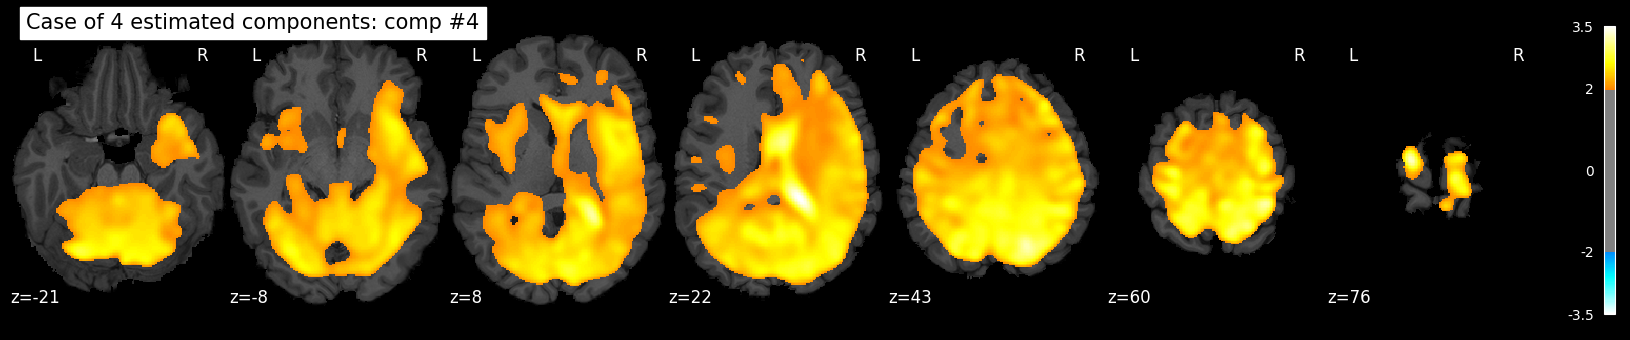

In [22]:
#* Plot the group-level independent components for the different number of requested components.
## Here you can use only 3 components to reduce the plots
## e.g. uncomment this if you used more than 3 values before
# nb_components = nb_components[:3]

for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(4, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

Now, copy-paste the cell above but change the display mode of the `plot_stat_map` function to be `ortho` instead of `z`.

Number of components:  4


/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


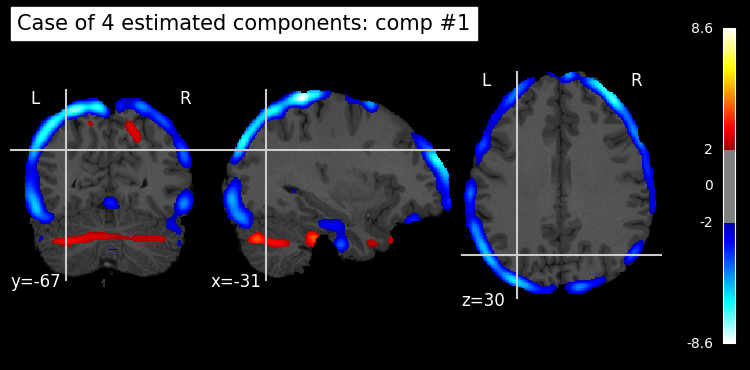

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


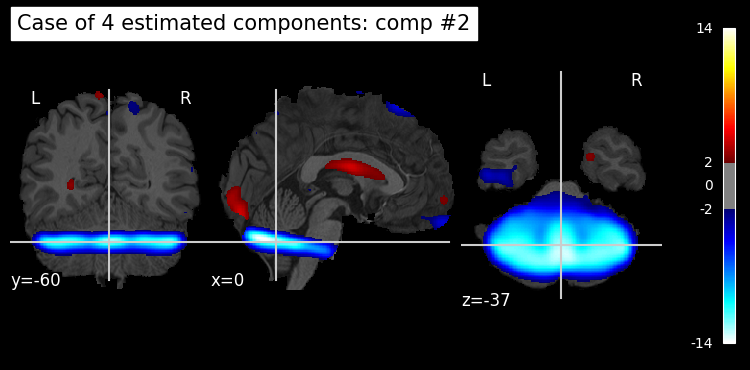

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


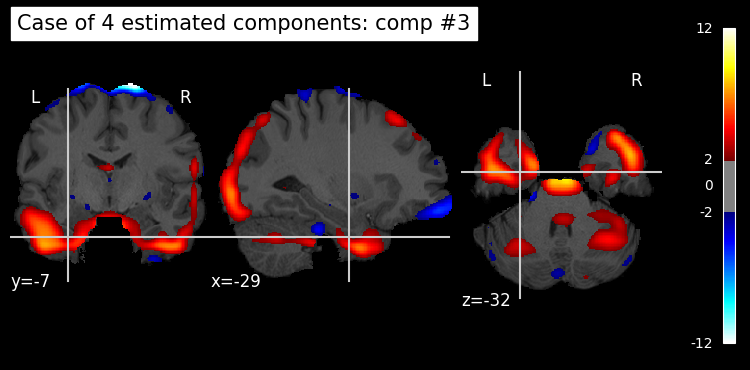

/Users/mikichan/miniconda3/envs/conn_grad/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


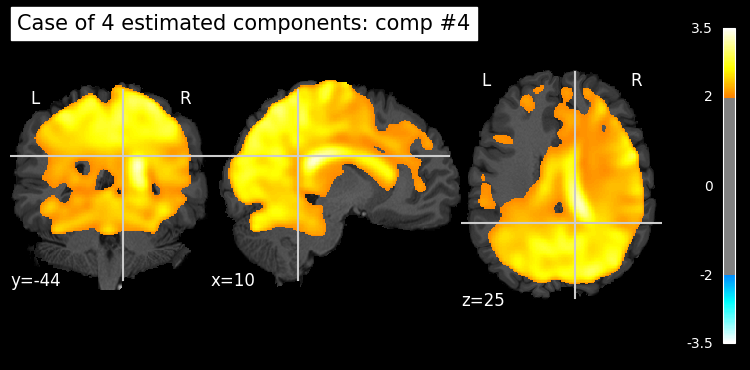

In [23]:
### YOUR CODE HERE
#* Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

#### Reflection points: observe what happens when increasing the number of components:

Using more independent components doesn't always provide more useful information!